<a href="https://colab.research.google.com/github/leoilgz/keras-laranjas/blob/main/keras_class_laranjas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Leo Dantas Ilg - RA:202110408 - Projeto Classificação de Laranjas - Atualizado: 17/11/2023**

### **1) Definição do Problema:**

 Classificar imagens de laranjas em 6 classes (C1 a C6) de acordo com sua maturidade, desde imatura (verde), ou C1 até estragada, ou C6.



*   Imports necessários para desenvolvimento do modelo utilizando o keras:



In [ ]:
import matplotlib.pyplot as plt # graficos p/ visualização
import numpy as np # computacao numerica em python
import os # manipular arquivos e pastas no S.O.
import PIL # manipular imagens em python
import tensorflow as tf # biblioteca p/ machine learning (tipo sklearn)

from tensorflow import keras # deep learning
from tensorflow.keras import layers # camadas de redes neurais
from tensorflow.keras.models import Sequential # redes neurais em sequencia
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

## **2) Coletando os dados:**

As imagens foram coletadas de datasets publicados no Kaggle e foram salvas em uma pasta do google drive para acesso em nuvem.

Link do drive utilizado:

https://drive.google.com/drive/folders/1Dk2kXQHaJVOaA0t_5n2ApFJw4S3HPgNz?usp=drive_link

Link para os datasets:

1) https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images

2) https://www.kaggle.com/datasets/ryandpark/fruit-quality-classification

3) https://www.kaggle.com/datasets/jppgomes/dataset-laranjas/



*   Importar o dataset de imagens:



In [ ]:
import pathlib # manipular caminhos de arquivos
from google.colab import drive #utilizar dados do google drive (banco de imagens)
drive.mount('/content/drive')

dataset_url='https://drive.google.com/drive/folders/1Dk2kXQHaJVOaA0t_5n2ApFJw4S3HPgNz?usp=sharing'

data_dir = '/content/drive/MyDrive/Laranjas/'

Mounted at /content/drive




*   Visualizando a rotulagem dos dados no Drive



In [ ]:
ls /content/drive/MyDrive/Laranjas

C1/  C2/  C3/  C4/  C5/  C6/


In [ ]:
import os
FOLDER_PATH = ["C1", "C2", "C3", "C4", "C5", "C6"]
ROOT_PATH = '/content/drive/MyDrive/Laranjas/'

for folder in FOLDER_PATH:
    folder_path = os.path.join(ROOT_PATH, folder)
    print(f"Quantidade de amostras {folder}: {len(os.listdir(folder_path))}")

Quantidade de amostras C1: 382
Quantidade de amostras C2: 148
Quantidade de amostras C3: 119
Quantidade de amostras C4: 98
Quantidade de amostras C5: 201
Quantidade de amostras C6: 217




*   Definindo parâmetros para as imagens que serão utilizadas:



In [ ]:
batch_size = 93  # numero de amostras processadas por vez -> batch = lote // hiperp.
img_height = 224
img_width = 224  # tamanho 224px X 224px -> comumente utilizado para imagens.


*   Definindo a quantidade de dados que serão usados para treino utilizando o keras:




In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # separando 20% dos dados para teste/validacao, sobrando 80% para treino
  subset="training", # setando os dados de treino
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1165 files belonging to 6 classes.
Using 932 files for training.



*   Definindo a quantidade de dados que serão utilizados para teste/validação utiliando o keras:



In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", # setando os dados de teste
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1165 files belonging to 6 classes.
Using 233 files for validation.




*   Visualização dos dados de treino rotuladas:



In [ ]:
class_names = train_ds.class_names
print(class_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6']


## **3) Formatação dos dados:**

Como estamos utilizando imagens pré-rotuladas, não há a necessidade de limpar o dataset, apenas adicionar novas imagens ao dataset para melhorar as métricas do modelo, mas isso é feito ao longo do tempo após visualizar os resultados que o modelo trouxe no final do projeto.

## **4) Explorando os dados:**
Como estamos lidando com imagens pré-rotuladas, apenas utilizaremos uma função para plotar algumas imagens puxadas de nossa pasta de laranjas, para verificar se os rótulos estão condizentes com a realidade, ou seja, se uma laranja classificada como C2 visualmente é uma laranja C2.


*   Visualização das imagens pré-rotuladas

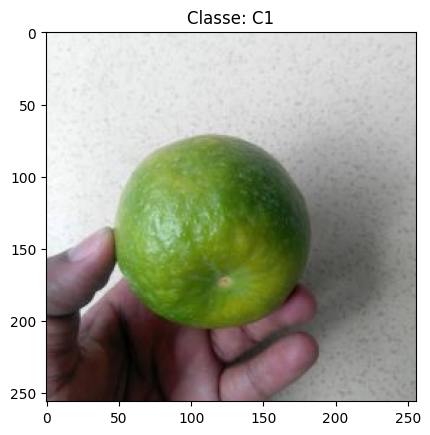

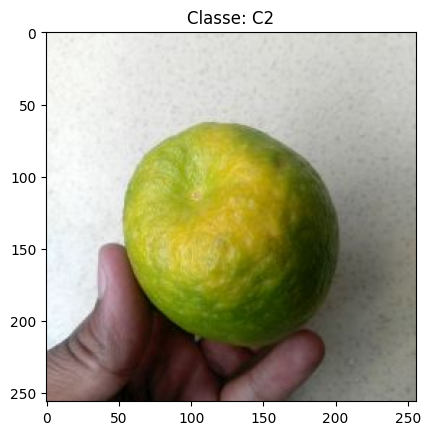

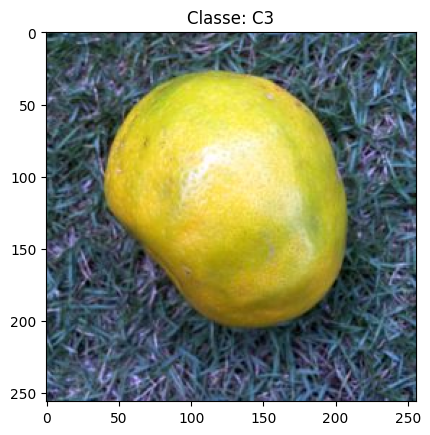

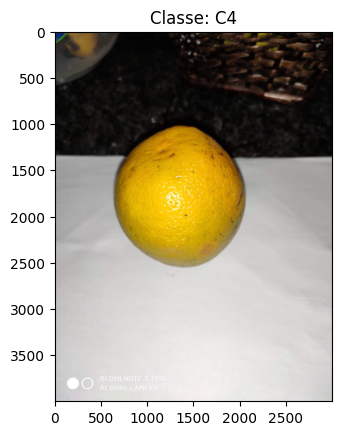

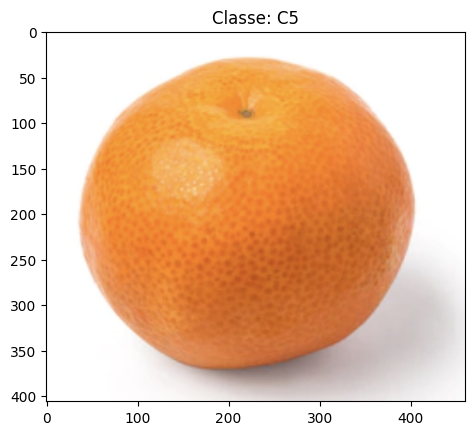

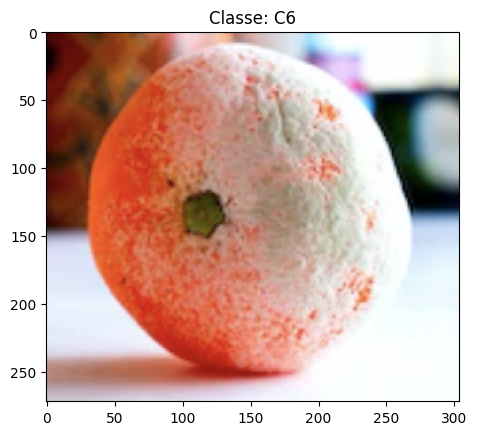

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Caminho do diretório principal
diretorio_principal = '/content/drive/MyDrive/Laranjas'

# Lista das classes
classes = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Exibindo uma imagem aleatória de cada classe
for classe in classes:
    caminho_classe = os.path.join(diretorio_principal, classe)
    imagens_classe = os.listdir(caminho_classe)

    if imagens_classe:
        imagem_escolhida = random.choice(imagens_classe)
        caminho_imagem = os.path.join(caminho_classe, imagem_escolhida)

        # Carregar e exibir a imagem
        img = mpimg.imread(caminho_imagem)
        plt.imshow(img)
        plt.title(f'Classe: {classe}')
        plt.show()
    else:
        print(f'Nenhuma imagem encontrada para a classe {classe}')

## **4) Preparação dos dados, ou Pré-Processamento:**

Nesta parte da solução, precisamos preparar os dados de forma que fique viável sua execução no modelo, pense como uma fase necessária para facilitar a execução do modelo. Como estamos lidando com imagens, é necessário um cuidado maior com essa parte, pois imagens são mais pesadas computacionalmente do que datasets que envolvem somente texto (caracteres).

* Configurar os dados para desempenho:
 * O código abaixo foi extraído de: https://www.tensorflow.org/tutorials/images/classification


In [ ]:
# Dataset.cache mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época.
# Isso garantirá que o conjunto de dados não se torne um gargalo ao treinar seu modelo.
# Dataset.prefetch sobrepõe o pré-processamento de dados e a execução do modelo durante o treinamento.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

* Normalizar os dados através da alteração da escala dos valores dos pixels da imagem:

In [ ]:
normalization_layer = layers.Rescaling(1./255) # Transformando a escala de 0-255 para 0-1

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Os valores dos pixels agora estão no intervalo [0,1].
print(np.min(first_image), np.max(first_image))

0.0 1.0


* Construção do modelo:
 * Aqui estamos criando nossa rede neural e definindo a arquitetura dela para tratar nossas imagens de forma ideal para que elas sejam devidamente identificadas e aproveitadas pelo nosso modelo. Esse tratamento das imagens que será realizado pela rede neural faz com que, além de deixar o treinamento mais barato computacionalmente, faz com que as cores nas imagens (o que é o princípio por trás de nossa classificação de laranjas) fiquem bem perceptíveis.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## **6) Treinar algoritmo**

Nesta parte apenas utilizaremos comandos do Keras para compilar e treinar nosso modelo.

* Compilar o modelo:

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) #adicionar mais métricas

model.summary() # visualizar as camadas da rede

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

* Treinar o modelo:

In [ ]:
epochs=10 #quantidade de "rodadas" que nosso dataset de treino passa pelo modelo, é um hiperparâmetro.
          #quanto mais épocas, mais poder computacional é necessário, ou seja, mais tempo.


history = model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 85s 8s/step - loss: 2.8523 - accuracy: 0.2876 - val_loss: 1.7298 - val_accuracy: 0.3305
Epoch 2/10
11/11 [==============================] - 55s 5s/step - loss: 1.5699 - accuracy: 0.4109 - val_loss: 1.3542 - val_accuracy: 0.5193
Epoch 3/10
11/11 [==============================] - 52s 5s/step - loss: 1.0515 - accuracy: 0.6330 - val_loss: 0.8873 - val_accuracy: 0.6481
Epoch 4/10
11/11 [==============================] - 64s 6s/step - loss: 0.7710 - accuracy: 0.7028 - val_loss: 0.6405 - val_accuracy: 0.7768
Epoch 5/10
11/11 [==============================] - 54s 5s/step - loss: 0.5469 - accuracy: 0.7854 - val_loss: 0.4879 - val_accuracy: 0.8240
Epoch 6/10
11/11 [==============================] - 56s 6s/step - loss: 0.3556 - accuracy: 0.8519 - val_loss: 0.3957 - val_accuracy: 0.8541
Epoch 7/10
11/11 [==============================] - 56s 5s/step - loss: 0.2863 - accuracy: 0.8723 - val_loss: 0.3622 - val_accuracy: 0.8584
Epoch 8/10
11/11 [==

## **7) Avaliação das métricas e dos dados resultantes do treinamento.**
Agora que nosso modelo está treinado, precisamos avaliar as métricas resultantes desse treinamento para que possamos decidir como o melhorar, se há algum problema com ele (como o overfitting ou falsos positivos e negativos).

* Visualizar dados de treinamento

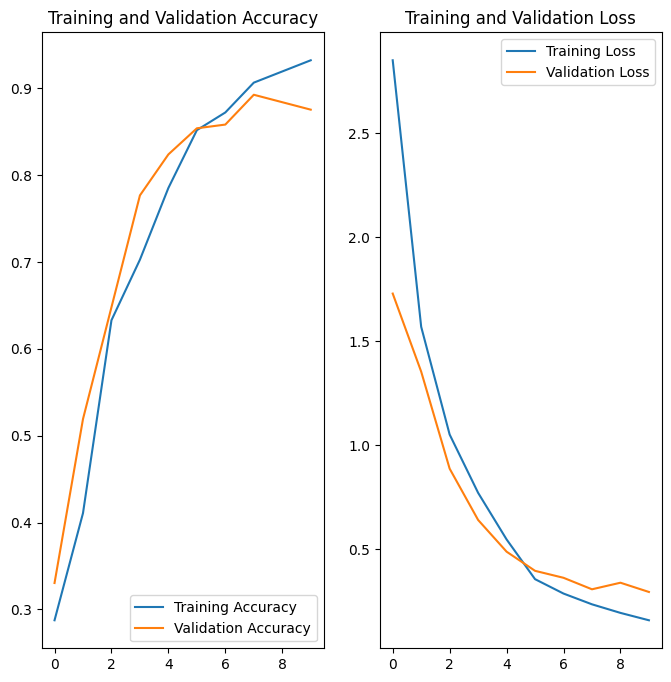

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#prestar atenção no que o gráfico dirá
#overfitting, underfitting, etc...

# Para melhorar os dados:

Podemos adicionar amostras através de rotação da imagem, jogar imagens ruins fora, adicionar novas imagens e etc...

Devemos iterar isso até conseguir boas métricas para o modelo.

## **8) Enviando uma imagem aleatória para testar o funcionamento do modelo:**

Para finalizar nosso projeto, iremos pegar uma imagem aleatória de laranja para o modelo "adivinhar" sua maturidade.


In [ ]:
from PIL import Image
from io import BytesIO
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

# Nomes disponíveis para teste:
# C1: images.jpg, 2221587-fresh-green-orange-isolated-on-white-background-gratis-foto.jpg
# C2: imageslaranja.jpg, laranjadownload.jpg
# C3: IMG_2533.JPG
# C4:
# C5: 360_F_56010077_UA98ADMw95rEB2hCuAlFOJkjdirrAAPV.jpg
# C6: 3828461-laranja-podre-e-mofada-foto.jpg

teste_path = '/content/drive/MyDrive/laranjas_teste/3828461-laranja-podre-e-mofada-foto.jpg' #para testar outras imagens, trocar o nome que a imagem tem no drive após a última '/'

img = Image.open(teste_path)

img = tf.keras.utils.load_img(
    teste_path, target_size=(img_height, img_width)
)

plt.imshow(img)
plt.axis('off') #esse bloco mostra a imagem
plt.show()

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Essa imagem provavelmente é uma Laranja {} com uma confiança de {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score)) #classe da laranja e confiança
)